In [6]:
import pyarrow.parquet as pq
import pyarrow as pa
import pyarrow.compute as pc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




In [7]:
import duckdb

In [3]:
import duckdb

parquet_file = r"D:/CapstoneTyler/0003_part_00.parquet"  # Use raw string for the file path

# Connect to DuckDB
con = duckdb.connect()

# Query to select the first 20 rows from the Parquet file
query = f"SELECT * FROM read_parquet('{parquet_file}') LIMIT 2"

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Print the result
print(result)

              load_ts         batch_id  \
0 2020-07-23 03:31:58  20200722-200233   
1 2020-09-14 03:48:44  20200913-200233   

                                           audit_zip  \
0  2020072301-i-040171543e1bfef37-jIaExLdxncKWJ3J...   
1  2020091319-i-04a9a906e1cd5620c-ynxe8XAXdxUbNWc...   

                                 audit_internal_path  \
0  SURV8__EventLogCollectionAnalyzerTask_74f2d193...   
1  SURV8__EventLogCollectionAnalyzerTask_cf1e9b8b...   

                               guid                  event_name  \
0  74f2d1932dc04bb49906308be466a688  kernel_general_12_os_start   
1  cf1e9b8b99874405bce67b0124f68612         Generic WLAN Events   

                           provider event_id                create_time  \
0  Microsoft-Windows-Kernel-General       12 2020-07-22 03:39:55.109954   
1                          Netwtw06     7021 2020-09-12 20:31:20.702643   

   create_dt channel                              hash  
0 2020-07-22  System  00000003d90a5bb008daf24471a9

In [4]:
parquet_dir = "D:/CapstoneTyler"

con = duckdb.connect()

query = f"""
SELECT * FROM read_parquet('{parquet_dir}/0007_part_36.parquet')
"""

df = con.execute(query).df()




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

KeyboardInterrupt: 

In [8]:
parquet_dir = "D:/CapstoneTyler"

# Corrected SQL query
query = f"""
WITH filtered_guids AS (
    SELECT guid, COUNT(*) AS occurrence_count
    FROM read_parquet('{parquet_dir}/0003_part_36.parquet')
    WHERE event_id = '19'
    GROUP BY guid
    HAVING COUNT(*) BETWEEN 0 and 9
),
guids_with_1001 AS (
    SELECT DISTINCT guid
    FROM read_parquet('{parquet_dir}/0003_part_36.parquet')
    WHERE event_id LIKE '%41%'
)
SELECT 
    (SELECT COUNT(*) FROM filtered_guids) AS total_filtered_guids,
    (SELECT COUNT(*) FROM filtered_guids fg
     JOIN guids_with_1001 g1001
     ON fg.guid = g1001.guid) AS total_with_1001,
    (CAST((SELECT COUNT(*) FROM filtered_guids fg
           JOIN guids_with_1001 g1001
           ON fg.guid = g1001.guid) AS FLOAT) /
     CAST((SELECT COUNT(*) FROM filtered_guids) AS FLOAT)) * 100 AS percentage_with_1001;
"""

# Execute the query
results = duckdb.query(query).df()
print(results)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   total_filtered_guids  total_with_1001  percentage_with_1001
0                  7377              698              9.461841


In [77]:
duckdb.query("""
WITH guid_counts AS (
    SELECT 
        guid,
        COUNT(CASE WHEN event_id = '19' THEN 1 END) AS has_19,
        COUNT(CASE WHEN event_id LIKE '%41%' OR event_id LIKE '%1001%' THEN 1 END) AS has_41_or_1001
    FROM 'data/errors0700.parquet'
    GROUP BY guid
),
classified_guids AS (
    SELECT 
        COUNT(*) AS total_guids,
        COUNT(CASE WHEN has_19 > 0 AND has_41_or_1001 > 0 THEN 1 END) AS count_with_41_or_1001_and_19,
        COUNT(CASE WHEN has_19 = 0 AND has_41_or_1001 = 0 THEN 1 END) AS count_with_neither
    FROM guid_counts
)
SELECT 
    count_with_41_or_1001_and_19 AS num_with_41_or_1001_and_19,
    count_with_neither AS num_with_neither,
    CAST(count_with_41_or_1001_and_19 AS FLOAT) / total_guids AS prob_with_41_or_1001_and_19,
    CAST(count_with_neither AS FLOAT) / total_guids AS prob_with_neither
FROM classified_guids;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────────────┬──────────────────┬─────────────────────────────┬───────────────────┐
│ num_with_41_or_1001_and_19 │ num_with_neither │ prob_with_41_or_1001_and_19 │ prob_with_neither │
│           int64            │      int64       │            float            │       float       │
├────────────────────────────┼──────────────────┼─────────────────────────────┼───────────────────┤
│                        883 │          2162151 │                0.0003883316 │        0.95088506 │
└────────────────────────────┴──────────────────┴─────────────────────────────┴───────────────────┘

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

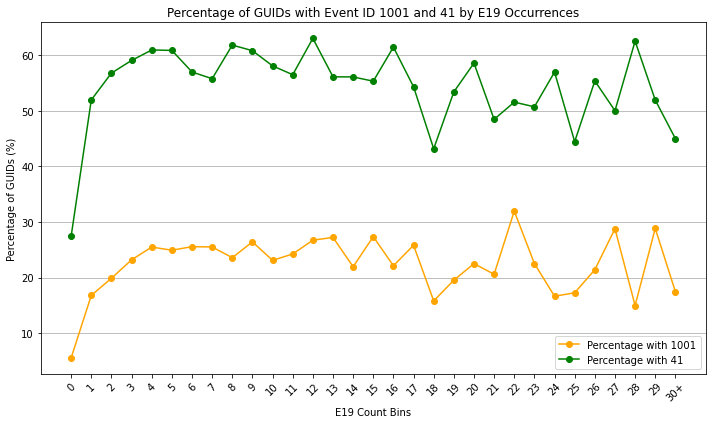

In [29]:
parquet_file = 'D:\CapstoneTyler\*.parquet'

# Connect to DuckDB and execute the query
query = f"""
WITH guid_counts AS (
    SELECT 
        guid,
        COUNT(CASE WHEN event_id = '19' THEN 1 END) AS e19_count,
        MAX(CASE WHEN event_id LIKE '%1001%' THEN 1 ELSE 0 END) AS has_1001,
        MAX(CASE WHEN event_id LIKE '%41%' THEN 1 ELSE 0 END) AS has_41
    FROM '{parquet_file}'
    GROUP BY guid
),
histogram AS (
    SELECT 
        CASE 
            WHEN e19_count >= 30 THEN '30+'
            ELSE CAST(e19_count AS VARCHAR)
        END AS bin,
        AVG(has_1001) * 100 AS percent_with_1001,
        AVG(has_41) * 100 AS percent_with_41
    FROM guid_counts
    GROUP BY bin
)
SELECT 
    bin,
    percent_with_1001,
    percent_with_41
FROM histogram
ORDER BY 
    CASE 
        WHEN bin = '30+' THEN 30 
        ELSE CAST(bin AS INTEGER) 
    END;
"""

# Execute the query and fetch results
df = duckdb.query(query).to_df()

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Adding percentage lines for 1001 and 41
plt.plot(df['bin'], df['percent_with_1001'], marker='o', color='orange', label='Percentage with 1001')
plt.plot(df['bin'], df['percent_with_41'], marker='o', color='green', label='Percentage with 41')

# Adding labels and title
plt.xlabel('E19 Count Bins')
plt.ylabel('Percentage of GUIDs (%)')
plt.title('Percentage of GUIDs with Event ID 1001 and 41 by E19 Occurrences')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

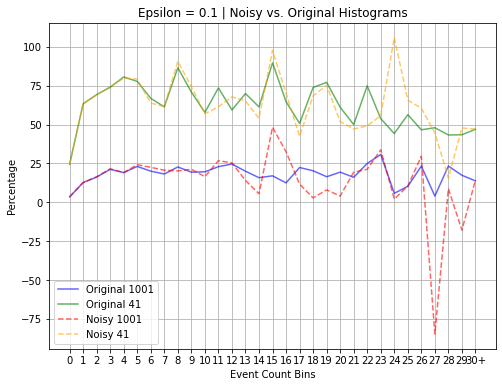

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

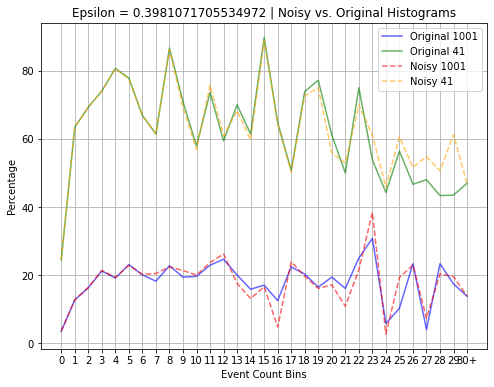

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

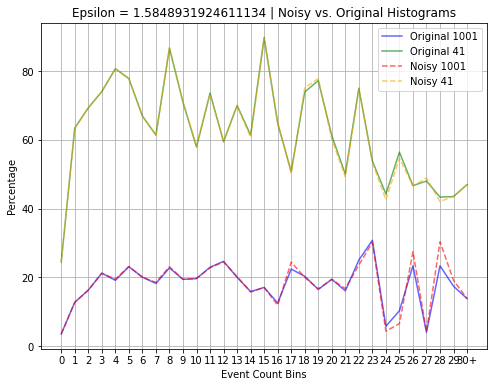

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

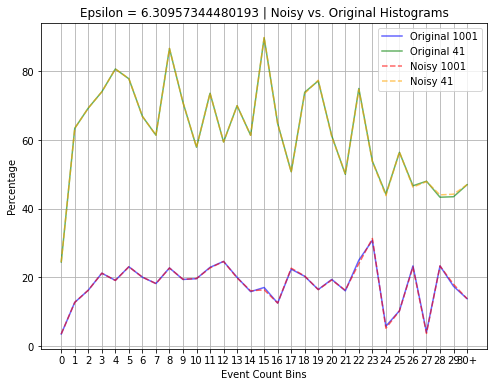

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

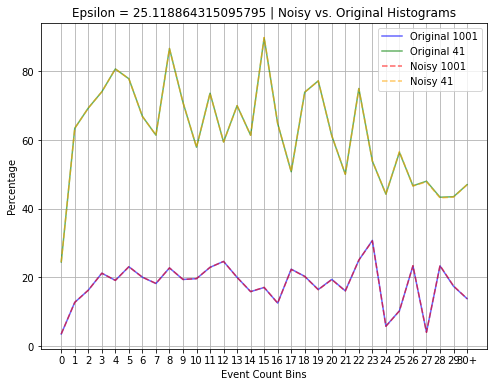

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

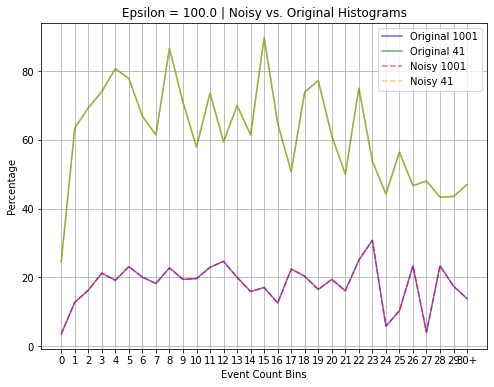

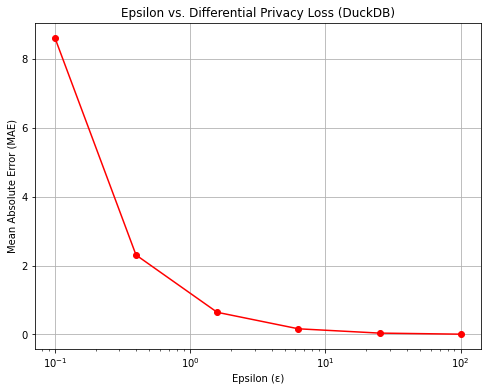

In [11]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np

parquet_files = [r"D:\CapstoneTyler\0007_part_00.parquet", r"D:\CapstoneTyler\0007_part_36.parquet", r"D:\CapstoneTyler\0007_part_38.parquet", r"D:\CapstoneTyler\0007_part_39.parquet", r"D:\CapstoneTyler\0007_part_40.parquet", r"D:\CapstoneTyler\0007_part_42.parquet" ]

# Step 1: Get dataset size (number of unique GUIDs)
guid_count_query = f"SELECT COUNT(DISTINCT guid) FROM read_parquet({parquet_files});"
num_guids = duckdb.query(guid_count_query).fetchone()[0]  # Fetch the total count

# Step 2: Define epsilon values
epsilon_values = np.logspace(-1, 2, 6)  # From 0.1 to 100

# Step 3: Compute sensitivity dynamically
sensitivity_percentage = 1   # Adjust based on actual dataset size

# Store loss values
loss_values = []

for epsilon in epsilon_values:
    # Compute Laplace scale
    b = sensitivity_percentage / epsilon

    # DuckDB SQL Query to count event occurrences
    query = f"""
    WITH guid_counts AS (
        SELECT 
            guid,
            COUNT(CASE WHEN event_id = '19' THEN 1 END) AS e19_count,
            SUM(CASE WHEN event_id LIKE '%1001%' THEN 1 ELSE 0 END) AS num_ones_1001,
            SUM(CASE WHEN event_id LIKE '%41%' THEN 1 ELSE 0 END) AS num_ones_41
        FROM read_parquet({parquet_files})
        GROUP BY guid
    ),
    histogram AS (
        SELECT 
            CASE 
                WHEN e19_count >= 30 THEN '30+'
                ELSE CAST(e19_count AS VARCHAR)
            END AS bin,
            SUM(num_ones_1001) AS num_ones_1001,
            COUNT(*) - SUM(num_ones_1001) AS num_zeros_1001,
            SUM(num_ones_41) AS num_ones_41,
            COUNT(*) - SUM(num_ones_41) AS num_zeros_41
        FROM guid_counts
        GROUP BY bin
    )
    SELECT 
        bin,
        num_ones_1001,
        num_zeros_1001,
        num_ones_41,
        num_zeros_41
    FROM histogram
    ORDER BY 
        CASE 
            WHEN bin = '30+' THEN 30 
            ELSE CAST(bin AS INTEGER) 
        END;
    """

    con = duckdb.connect()
    df_original = con.execute(query).fetch_df()
    con.close()

    # Add Laplace noise to both counts
    df_noisy = df_original.copy()
    df_noisy['num_ones_1001'] += np.random.laplace(0, b, len(df_noisy))
    df_noisy['num_zeros_1001'] += np.random.laplace(0, b, len(df_noisy))
    df_noisy['num_ones_41'] += np.random.laplace(0, b, len(df_noisy))
    df_noisy['num_zeros_41'] += np.random.laplace(0, b, len(df_noisy))

    # Compute percentages
    df_original['percent_with_1001'] = (df_original['num_ones_1001'] / (df_original['num_ones_1001'] + df_original['num_zeros_1001'])) * 100
    df_original['percent_with_41'] = (df_original['num_ones_41'] / (df_original['num_ones_41'] + df_original['num_zeros_41'])) * 100

    df_noisy['percent_with_1001'] = (df_noisy['num_ones_1001'] / (df_noisy['num_ones_1001'] + df_noisy['num_zeros_1001'])) * 100
    df_noisy['percent_with_41'] = (df_noisy['num_ones_41'] / (df_noisy['num_ones_41'] + df_noisy['num_zeros_41'])) * 100

    # Compute Mean Absolute Error (MAE)
    loss_1001 = np.mean(np.abs(df_original['percent_with_1001'] - df_noisy['percent_with_1001']))
    loss_41 = np.mean(np.abs(df_original['percent_with_41'] - df_noisy['percent_with_41']))
    
    loss_values.append((loss_1001 + loss_41) / 2)  # Average loss

    # Plot the noisy and non-private histograms
    plt.figure(figsize=(8, 6))
    plt.plot(df_original['bin'], df_original['percent_with_1001'], alpha=0.6, label='Original 1001', color='blue')
    plt.plot(df_original['bin'], df_original['percent_with_41'], alpha=0.6, label='Original 41', color='green')

    plt.plot(df_noisy['bin'], df_noisy['percent_with_1001'], alpha=0.6, label='Noisy 1001', color='red', linestyle='dashed')
    plt.plot(df_noisy['bin'], df_noisy['percent_with_41'], alpha=0.6, label='Noisy 41', color='orange', linestyle='dashed')

    plt.xlabel("Event Count Bins")
    plt.ylabel("Percentage")
    plt.title(f"Epsilon = {epsilon} | Noisy vs. Original Histograms")
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 4: Plot ε vs. Loss
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, loss_values, marker='o', linestyle='-', color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel('Epsilon (ε)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Epsilon vs. Differential Privacy Loss (DuckDB)')
plt.grid(True)
plt.show()